# Set up

Setting up libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/Data

/content/drive/My Drive/Colab Notebooks/Data


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import glob
import pickle
import seaborn as sns

from skimage.transform import radon, iradon
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn import metrics


# Setting seed for reproducibility
SEED = 42
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
keras.utils.set_random_seed(SEED)

# Opening variables with pickle

In [ ]:
with open('variables', 'rb') as f:
   train,train_labs,valid,valid_labs,test,test_labs,test_labels = pickle.load(f)

In [ ]:
with open('angles', 'rb') as f:
   best_angle = pickle.load(f)

# Apply random angles to data set

In [ ]:
def new_set(train):
  old_train = train
  new_train = []
  for i in range(len(train)):
    new_train.append(old_train[i,:,:]*best)
  return np.array(new_train)

In [ ]:
best_angle = np.round(np.array(best_angle),1)
count = np.count_nonzero(best_angle)
rand_one = np.ones((1,count))
rand_zero = np.zeros((1,(256-count)))
random_angle = np.concatenate((rand_one,rand_zero),axis = 1)[0]
np.random.shuffle(random_angle)

In [ ]:
random_angle = np.reshape(random_angle,(1,256))
best = np.repeat(random_angle, 256, axis = 0)
best = np.repeat(best[..., np.newaxis], 3, -1)
new_train = new_set(train)
new_valid = new_set(valid)
new_test = new_set(test)

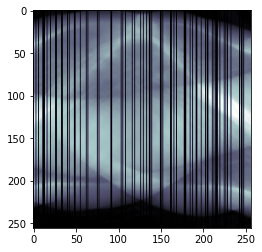

In [ ]:
sns.reset_orig()
plt.imshow(new_test[0,:,:,0], cmap = 'bone')

Number of columns missing

In [ ]:
np.count_nonzero(random_angle)

190

Percent of sinogram missing

In [ ]:
np.count_nonzero(random_angle)/256*100

74.21875

# Standard model

In [ ]:
inception = InceptionV3(weights= 'imagenet',
                        include_top=False,
                        input_shape=(256,256,3)
)

for layer in inception.layers:
    layer.trainable = False

x = inception.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(4, activation = "softmax")(x)
model = Model(inputs= inception.input , outputs = x)

In [ ]:
loss_fn_name = "categorical_crossentropy"
Metrics = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

model.compile(optimizer=optimizers.Adam(learning_rate=0.001),loss=loss_fn_name, metrics=Metrics)

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', verbose=1, patience=7)

mcp = tf.keras.callbacks.ModelCheckpoint('random_model.h5',monitor='val_auc', mode='max', save_best_only=True)

history = model.fit(new_train, train_labs, epochs=35, batch_size=64, validation_data=(new_valid, valid_labs),callbacks=[es,mcp])

Epoch 1/35
10/10 [==============================] - 114s 11s/step - loss: 101351.7500 - accuracy: 0.3394 - precision: 0.3394 - recall: 0.3394 - auc: 0.5596 - val_loss: 68305.9609 - val_accuracy: 0.3750 - val_precision: 0.3750 - val_recall: 0.3750 - val_auc: 0.5833
Epoch 2/35
10/10 [==============================] - 106s 11s/step - loss: 43968.0547 - accuracy: 0.3594 - precision: 0.3594 - recall: 0.3594 - auc: 0.5729 - val_loss: 30832.7539 - val_accuracy: 0.3889 - val_precision: 0.3889 - val_recall: 0.3889 - val_auc: 0.5926
Epoch 3/35
10/10 [==============================] - 107s 11s/step - loss: 14752.6055 - accuracy: 0.4476 - precision: 0.4476 - recall: 0.4476 - auc: 0.6317 - val_loss: 15460.8926 - val_accuracy: 0.4306 - val_precision: 0.4306 - val_recall: 0.4306 - val_auc: 0.6204
Epoch 4/35
10/10 [==============================] - 106s 11s/step - loss: 9343.0361 - accuracy: 0.5358 - precision: 0.5358 - recall: 0.5358 - auc: 0.6905 - val_loss: 4931.1089 - val_accuracy: 0.5972 - val_pr

In [ ]:
best_model = load_model('random_model.h5')
best_model.evaluate(x = new_test, y = test_labs, verbose=1)

10/10 [==============================] - 46s 4s/step - loss: 4076.8579 - accuracy: 0.5048 - precision: 0.5048 - recall: 0.5048 - auc: 0.6698


[4076.85791015625,
 0.5047619342803955,
 0.5047619342803955,
 0.5047619342803955,
 0.6698412895202637]

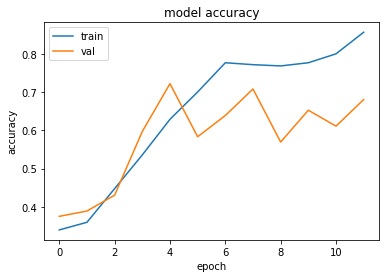

In [ ]:
sns.reset_orig()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

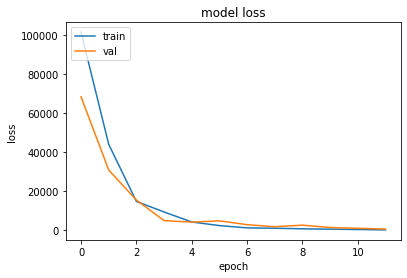

In [ ]:
sns.reset_orig()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
preds = best_model.predict(new_test)

In [ ]:
cf_matrix = confusion_matrix(test_labels, preds.argmax(axis=1))

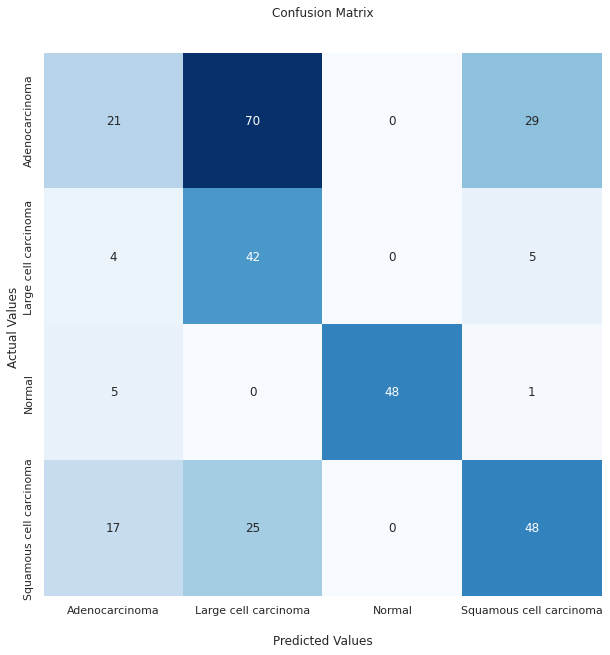

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',cbar=False,fmt='g')

ax.set_title('Confusion Matrix for Random Angle Model\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Adenocarcinoma','Large cell carcinoma','Normal','Squamous cell carcinoma'])
ax.yaxis.set_ticklabels(['Adenocarcinoma','Large cell carcinoma','Normal','Squamous cell carcinoma'])

plt.show()

In [ ]:
def four_to_two(pred):
  pred_2 = [] 
  for i in range(len(pred)):
    if pred[i] == 0 or pred[i] == 1 or pred[i] == 3: 
      pred_2.append(1)
    else:
      pred_2.append(0)
  return pred_2

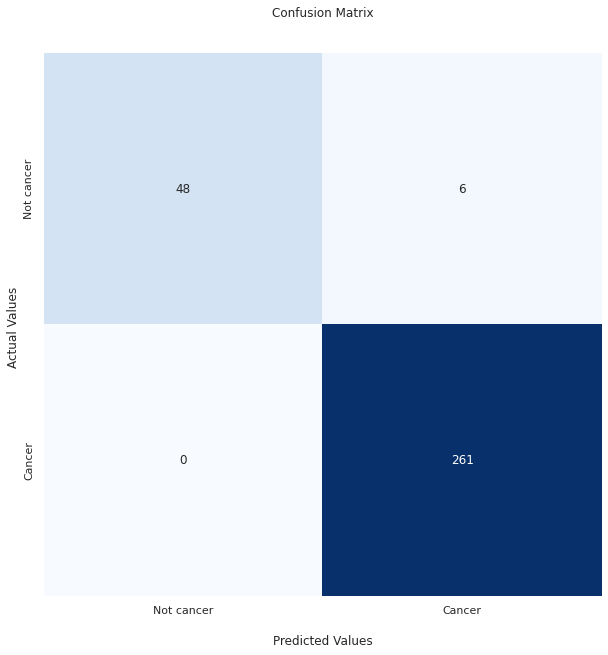

In [ ]:
preds_in_one = preds.argmax(axis=1)

new_pred = four_to_two(preds_in_one)
new_test_labels = four_to_two(test_labels)

cf_matrix_2 = confusion_matrix(new_test_labels, new_pred)

sns.set(rc={'figure.figsize':(10,10)})

ax = sns.heatmap(cf_matrix_2, annot=True, cmap='Blues',cbar=False,fmt = 'g')

ax.set_title('Cancer Detection Matrix for Random Angle Model\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(['Not cancer','Cancer'])
ax.yaxis.set_ticklabels(['Not cancer','Cancer'])

plt.show()

#  Metrics

In [ ]:
def scores(y_true, y_pred, labels):
  acc = metrics.accuracy_score(y_true, y_pred.argmax(axis=1))
  acc_k = metrics.top_k_accuracy_score(y_true, y_pred, k=2)
  acc_3 = metrics.top_k_accuracy_score(y_true, y_pred, k=3)
  prec = metrics.precision_score(y_true, y_pred.argmax(axis=1), average = 'weighted')
  rec = metrics.recall_score(y_true, y_pred.argmax(axis=1), average = 'weighted')
  roc_auc = metrics.roc_auc_score(labels, y_pred)

  print('Accuracy is :',round(acc,3))
  print('Top 2 Accuracy is :',round(acc_k,3))
  print('Top 3 Accuracy is :',round(acc_3,3))
  print('Precision is :',round(prec,3))
  print('Recall is :',round(rec,3))
  print('AUC is :',round(roc_auc,3))

In [ ]:
scores(test_labels,preds,test_labs)

Accuracy is : 0.505
Top 2 Accuracy is : 0.638
Top 3 Accuracy is : 0.673
Precision is : 0.557
Recall is : 0.505
AUC is : 0.72
